# Fit S(Q)

In [1]:
# Chi-Huan Tung
# National Tsing-Hua University
# Aug 2021
#
# Fit the I(Q) curve using the S(Q) generated by pre-trained cVAE model
# Infer potential parameters from optimized latent variables using GPR
# tensorflow 2.6.0
# sklearn 0.24.2

## Setup

In [2]:
fit_SQ = 0
fit_resolution = 0

In [3]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
plt.rc('font',family='Arial')
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import scipy.interpolate as interp
tf.config.run_functions_eagerly(True)

Assign device (GPU)

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Load data

### Training set

In [6]:
# minimum sq
sq_min = np.exp(-5)

In [7]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX = open(X_file, 'r', encoding='utf-8-sig')
sq = np.genfromtxt(fX, delimiter=',').astype(np.float32)
sq[sq<=0] = sq_min

fY = open(Y_file, 'r', encoding='utf-8-sig')
target = np.genfromtxt(fY, delimiter=',').astype(np.float32)

In [8]:
if 0:
    sq = np.vstack((sq[0:7500,:],sq))
    target = np.vstack((target[0:7500,:],target))

In [9]:
sq.shape

(18750, 80)

In [10]:
eta = target[:,0]
kappa = target[:,1]
Z = target[:,3]
A = target[:,2]
lnZ = np.log(Z)
lnA = np.log(A)

In [11]:
sq_dim = sq.shape[1]
sample_train_dim = sq.shape[0]

$Q\cdot r_\textrm{ave}$

In [12]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [13]:
r_eta = 1
sq_rs = np.zeros((sample_train_dim,q_rs_dim),dtype='float32')
for i in range(sample_train_dim):
    qr_eta = q*r_eta
    interpolating_function = interp.interp1d(qr_eta[3:],sq[i,3:],fill_value='extrapolate')
    sq_rs[i,:] = interpolating_function(q_rs).astype(np.float32)
sq_rs[sq_rs<=0] = sq_min

### Test set

In [14]:
# minimum sq
sq_min = np.exp(-5)

In [15]:
if 1:
    X_file = '../data/input_grid_all_GPR80.csv'
    Y_file = '../data/target_grid_all.csv'
else:
    X_file = '../data/input_random_all_GPR80.csv'
    Y_file = '../data/target_random_all.csv'
    
fX_test = open(X_file, 'r', encoding='utf-8-sig')
sq_test = np.genfromtxt(fX_test, delimiter=',').astype(np.float32)
sq_test[sq_test<=0] = sq_min

fY_test = open(Y_file, 'r', encoding='utf-8-sig')
target_test = np.genfromtxt(fY_test, delimiter=',').astype(np.float32)

In [16]:
sq_test.shape

(18750, 80)

In [17]:
eta_test = target_test[:, 0]
kappa_test = target_test[:, 1]
Z_test = target_test[:, 3]
A_test = target_test[:, 2]
lnZ_test = np.log(Z_test)
lnA_test = np.log(A_test)

In [18]:
sq_dim = sq_test.shape[1]
sample_test_dim = sq_test.shape[0]

$Q\cdot r_\textrm{ave}$

In [19]:
q = (np.arange(sq_dim)+1)*0.2
q_rs = (np.arange(sq_dim)+1)*0.2
q_rs_dim = q_rs.shape[0]

Rescale

In [20]:
r_eta_test = 1
sq_test_rs = np.zeros((sample_test_dim,q_rs_dim),dtype='float32')
for i in range(sample_test_dim):
    qr_eta = q*r_eta_test
    interpolating_function_test = interp.interp1d(qr_eta[3:],sq_test[i,3:],
                                                  fill_value='extrapolate',kind='linear')
    sq_test_rs[i,:] = interpolating_function_test(q_rs)
sq_test_rs[sq_test_rs<=0] = sq_min

### Mask

In [21]:
mask_length = 0
sq_mask = sq_rs
sq_test_mask = sq_test_rs

for i in range(sample_train_dim):
    sq_mask[i,0:mask_length] = sq_rs[i,mask_length]
for i in range(sample_test_dim):
    sq_test_mask[i,0:mask_length] = sq_test_mask[i,mask_length]

### Preprocess/Postprocess

In [22]:
exp_scale = 6

def f_inp(sq):
    return np.log(sq)/exp_scale/2 + 0.5

def f_out(predictions):
    return np.exp((predictions*2-1)*exp_scale)

In [23]:
### EQ-SANS Resolution Function

In [24]:
from scipy.io import loadmat
filename_EQSANS = './EQSANS.mat'
loaded_EQSANS = loadmat(filename_EQSANS)
q_EQSANS_0 = loaded_EQSANS['Q_real'].astype('float32')
qsig_EQSANS = loaded_EQSANS['qsig'].astype('float32')
qsig_EQSANS[qsig_EQSANS==0] = np.ones(np.sum(qsig_EQSANS==0))*np.min(qsig_EQSANS[qsig_EQSANS!=0])
q_EQSANS = q_EQSANS_0*16/max(q_EQSANS_0)
qsig_EQSANS = qsig_EQSANS*16/max(q_EQSANS_0)*3

## Network architecture

In [25]:
class VAE(tf.keras.Model):
    def __init__(self, latent_dim, sq_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        regularizer = None
        self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(sq_dim)),
            tf.keras.layers.Reshape((sq_dim,1)),
            tf.keras.layers.Conv1D(
                filters=32, kernel_size=3, strides=2, activation='relu',
                kernel_regularizer = regularizer,
                name='conv1d_en'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(
                latent_dim + latent_dim, 
                kernel_regularizer = regularizer,
                name='dense_en'),
        ]
        )
        
        self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(
                40*32, activation=tf.nn.relu, 
                kernel_regularizer = regularizer,
                name='dense_de'),
            tf.keras.layers.Reshape(target_shape=(40, 32)),
            tf.keras.layers.Conv1DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same', activation='relu',
                kernel_regularizer = regularizer,
                name='conv1dtrs_de'),
            tf.keras.layers.Conv1DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape((sq_dim,))
        ]
        )
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = 0*tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [26]:
latent_dim = 3
model = VAE(latent_dim, q_rs_dim)

## Load trained model

In [27]:
export_path = './saved_model/SQ_cVAE_MSE_ns/'
model_name = 'model_conv_stride2_exp6'
export_name = export_path + model_name

In [28]:
reload_sm = model.load_weights(export_name, by_name=False, skip_mismatch=False, options=None)
reload_sm.__dict__

{'_checkpoint': <tensorflow.python.training.tracking.util._CheckpointRestoreCoordinator at 0x18b39a06fd0>,
 '_feed_dict': None,
 '_graph_view': <tensorflow.python.training.tracking.graph_view.ObjectGraphView at 0x18b41eb74f0>,
 '_root': <__main__.VAE at 0x18b40378e80>}

In [29]:
model_r = reload_sm._root
#model_r.__dict__

### Loaded network architecture

In [30]:
class VAE_r():
    def __init__(self):
        self.encoder = model_r.encoder
        self.decoder = model_r.decoder
        
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(1000, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
        
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
M = VAE_r() # loaded model

In [31]:
def decoder_mean(model,lv):
    x = model.sample(lv)
    
    return x

def encoder_mean(model,x):
    mean = model.encode(x)[0]
    
    return mean

## Define functions 

In [32]:
exp_scale = 6

@tf.function
def f_inp_tf(sq):
    return tf.math.log(sq)/exp_scale/2 + 0.5

@tf.function
def f_out_tf(predictions):
    return tf.math.exp((predictions*2-1)*exp_scale)

In [33]:
def to_tf(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

In [34]:
def hardsphere(q,sigma=1):
    R = to_tf(sigma/2)
    P = (3*(tf.math.sin(q*R)-q*R*tf.math.cos(q*R))/(q*R)**3)**2
    return P

def interp_tf(q,qo,x):
    x_interp = tfp.math.interp_regular_1d_grid(
        to_tf(qo), tf.math.reduce_min(to_tf(q)), tf.math.reduce_max(to_tf(q)), x)
    return x_interp

def IQ_resoln(Q, Q_fine, IQ_th, dQ):
    '''
    Q: Q of the instrument resolution function
    dQ: The instrument resolution function
    Q_fine: A set of smooth Q points
    IQ_th: I(Q), interpolated to Q_fine
    '''
    Q = to_tf(Q)
    Q_fine = to_tf(Q_fine)
    IQ_th = to_tf(IQ_th)
    dQ = to_tf(dQ)
    Qmean = to_tf(Q)
    
    N = len(Q)
    IQ = []
    
    for i in range(N):
        current_dQ = dQ[i]
        current_Qmean = Qmean[i]
        IQ_resoln = IQ_th*(1/tf.math.sqrt(2*np.pi*current_dQ**2))*tf.math.exp(-(Q_fine-current_Qmean)**2/(2*current_dQ**2))
        IQ.append(tfp.math.trapz(IQ_resoln,Q_fine))

    IQ_out = tf.stack(IQ)
    return IQ_out
    
def scale_tf(q,x,scale):
    qs = q*scale
    x_interp = tfp.math.interp_regular_1d_grid(
        to_tf(qs), tf.math.reduce_min(to_tf(q)), tf.math.reduce_max(to_tf(q)), x)
    return x_interp

def SQ_th(model, fp):
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # interpolation
    #S_interp = scale_tf(q,S,fp[3])
    
    return S

def IQ_th(model, fp):
    # form factor
    P = hardsphere(q,fp[3])
    
    # structure factor
    lv = tf.reshape(to_tf(fp[0:3]),(1,3))
    x_logit = decoder_mean(model,lv)
    S = f_out_tf(x_logit)
    
    # I(Q)
    if fit_SQ==1:
        IQ_th = S[0,:]
    else:
        IQ_th = (S*P)[0,:]
    
    # interpolation    
    if fit_resolution==1:
        Q = q_EQSANS
        dQ = qsig_EQSANS
        
        Q_fine = np.linspace(0.2,16,100)
        IQ_th_new = interp_tf(q,Q_fine,IQ_th)
        
        IQ_res = IQ_resoln(Q, Q_fine, IQ_th_new, dQ)
        
        IQ_th_interp = scale_tf(q,IQ_res,fp[3])
        
    else:
        IQ_th_interp = scale_tf(q,IQ_th,fp[3])
    
    return IQ_th_interp

def fit_loss(model, x, fp):
    x_th = IQ_th(model, fp)
    
    # mean-square error
    err = tf.reduce_mean((tf.math.log(x_th)-tf.math.log(x))**2)
    
    return err

In [35]:
@tf.function
def train_step(model, x, fp, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = fit_loss(model, x, fp)
    gradients = tape.gradient(loss, fp)
    optimizer.apply_gradients(zip(gradients, fp))

In [36]:
from scipy import interpolate
def generate_image(model, IQ_exp, fp, epoch=0):
    error = fit_loss(model, IQ_exp, fp)
    IQ_th_current = IQ_th(model, fp)        
    
    #display.clear_output(wait=False)
    
    fig = plt.figure(figsize=(8, 6))
    ax = plt.subplot(1, 1, 1)
    
    plt.plot(q,IQ_exp,'sk') # plot IQ_exp
    #plt.plot(q,IQ_th_current,'b')
    
    q_new = np.logspace(np.log10(0.2),np.log10(16),500)
    spl = interpolate.InterpolatedUnivariateSpline(q,IQ_th_current)
    IQ_th_new = spl(q_new)
    
    plt.plot(q_new,IQ_th_new,'b') # plot current IQ_th
    
    fp_s = (np.matmul([fp[0:3],]-z_mean,U)*sgn)[0]
    
    plt.text(0.8,0.96,'MSE = {:.2e}'.format(error),transform=ax.transAxes)
    #plt.text(0.8,0.96,'lv[0] = {:+.2f}'.format(fp_s[0]),transform=ax.transAxes)
    #plt.text(0.8,0.90,'lv[1] = {:+.2f}'.format(fp_s[1]),transform=ax.transAxes)
    #plt.text(0.8,0.84,'lv[2] = {:+.2f}'.format(fp_s[2]),transform=ax.transAxes)
    #plt.text(0.8,0.78,'$\sigma$ = {:+.2f}'.format(fp[3].numpy()),transform=ax.transAxes)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlim(3, 16)
    #plt.ylim(3e-4, 0.3)
    plt.xlabel('$Q$')
    plt.ylabel('$I(Q)$')
    
    if fit_resolution==1:
        pngname = './figures_SQ_cVAE_MSE_ns/fit_res/fit_IQ_{:04d}.png'
    else:
        pngname = './figures_SQ_cVAE_MSE_ns/fit/fit_IQ_{:04d}.png'
    plt.savefig(pngname.format(epoch))
    plt.close()
    #plt.show()
    #print('epoch = {:04d}'.format(epoch))
    #time.sleep(0.1)

## Pick an I(Q) and test

In [37]:
index_test = 16609 #9202
sigma_test = 1.00
SQ_exp = sq_test_mask[index_test,:]
lv_GT = encoder_mean(M,to_tf(f_inp(SQ_exp.reshape((1,80)))))

SQ_exp = to_tf(SQ_exp)
P = hardsphere(q,1)

if fit_SQ==1:
    IQ_exp = SQ_exp
else:
    IQ_exp = SQ_exp*P
    
if fit_resolution==1:
    Q = q_EQSANS
    dQ = qsig_EQSANS
        
    Q_fine = np.linspace(0.2,16,100)
    spl = interpolate.InterpolatedUnivariateSpline(q,IQ_exp)
    IQ_exp_new = spl(Q_fine)
        
    IQ_res = IQ_resoln(Q, Q_fine, to_tf(IQ_exp_new), dQ)
        
    IQ_exp = scale_tf(q,IQ_res,sigma_test)
else:
    IQ_exp = scale_tf(q,IQ_exp,sigma_test)

fp_GT = [lv_GT[0,0],lv_GT[0,1],lv_GT[0,2],to_tf(sigma_test)]

### Initial value

In [38]:
with np.load(export_path +'lv_SVD_exp6.npz') as data:
    z_mean = data['z_mean']
    U = data['U']
    sgn = data['sgn']

In [39]:
# tf.constant("Initial Guess")
def initial_guess_transform(lv_s = [-1,0,1]):
    lv = to_tf(np.matmul(lv_s*sgn,U.T) + z_mean)
    return lv

sigma_i = tf.constant(1.00)
lv0_i = tf.constant(initial_guess_transform()[0])
lv1_i = tf.constant(initial_guess_transform()[1])
lv2_i = tf.constant(initial_guess_transform()[2])

# constraint=lambda t: tf.clip_by_value(t, "Lower Bound", "Upper Bound")
sigma = tf.Variable(sigma_i, name='sigma', dtype=tf.float32, 
                    constraint=lambda t: tf.clip_by_value(t, 1.0, 1.0))
lv0 = tf.Variable(lv0_i, name='lv0', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv1 = tf.Variable(lv1_i, name='lv1', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))
lv2 = tf.Variable(lv2_i, name='lv2', dtype=tf.float32, 
                 constraint=lambda t: tf.clip_by_value(t, -10, 10))

fp = [lv0,lv1,lv2,sigma]

### fitting parameters summary

In [40]:
fp_s = (np.matmul([fp[0:3],]-z_mean,U)*sgn)[0]
fp_GT_s = (np.matmul([fp_GT[0:3],]-z_mean,U)*sgn)[0]

In [41]:
string_fp    = 'fp      = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp[0].numpy(),fp[1].numpy(),fp[2].numpy())
string_fp_GT = 'fp_GT   = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_GT[0].numpy(),fp_GT[1].numpy(),fp_GT[2].numpy())
string_fp_s    = 'fp_s    = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_s[0],fp_s[1],fp_s[2])
string_fp_GT_s = 'fp_GT_s = {:0.4f}, {:0.4f}, {:0.4f}\n'.format(fp_GT_s[0],fp_GT_s[1],fp_GT_s[2])
print(string_fp + string_fp_GT + string_fp_s + string_fp_GT_s)

fp      = 0.4706, 0.7382, 1.3603
fp_GT   = -1.5770, 0.9143, -0.3320
fp_s    = -1.0000, 0.0000, 1.0000
fp_GT_s = 1.4136, -0.4496, -0.0298



## Test GPR model

### load trained GPR model

In [42]:
parameters = (eta_test,kappa_test,lnA_test)
parameters_GP = np.vstack(parameters).T
index_eta = np.arange(sq_test.shape[0])

parameters_GT = parameters_GP[index_test,:]

In [43]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import joblib

In [44]:
export_path_GPR = './saved_model/GPR/' 
model_name_GPR_eta = 'sklearn/SQ_GPR_eta'
model_name_GPR_kappa = 'sklearn/SQ_GPR_kappa'
model_name_GPR_lnA = 'sklearn/SQ_GPR_lnA'
export_name_GPR_eta = export_path_GPR + model_name_GPR_eta
export_name_GPR_kappa = export_path_GPR + model_name_GPR_kappa
export_name_GPR_lnA = export_path_GPR + model_name_GPR_lnA
gp_eta = joblib.load(export_name_GPR_eta)
gp_kappa = joblib.load(export_name_GPR_kappa)
gp_lnA = joblib.load(export_name_GPR_lnA)

In [45]:
predict_eta = gp_eta.predict(SQ_th(M, fp).numpy(), return_std=True)
predict_kappa = gp_kappa.predict(SQ_th(model, fp).numpy(), return_std=True)
predict_lnA = gp_lnA.predict(SQ_th(M, fp).numpy(), return_std=True)
parameters_predict = [predict_eta,predict_kappa,predict_lnA]

In [46]:
print('Ground truth: \n--- eta = {:0.4f} \n--- kappa = {:0.4f} \n--- lnA = {:0.4f}\n'
      .format(parameters_GT[0],parameters_GT[1],parameters_GT[2]))
print('Predictions: \n--- eta = {:0.4f} +- {:0.4f} \n--- kappa = {:0.4f} +- {:0.4f} \n--- lnA = {:0.4f} +- {:0.4f}'
      .format(parameters_predict[0][0][0],parameters_predict[0][1][0],
              parameters_predict[1][0][0],parameters_predict[1][1][0],
              parameters_predict[2][0][0],parameters_predict[2][1][0]))

Ground truth: 
--- eta = 0.4050 
--- kappa = 0.3000 
--- lnA = 2.3026

Predictions: 
--- eta = 0.2485 +- 0.0083 
--- kappa = 2.2394 +- 0.7451 
--- lnA = -0.0009 +- 1.0091


### training sets

In [47]:
x = to_tf(f_inp(sq_test_mask))
mean, logvar = model.encode(x)
z = model.reparameterize(mean, logvar)
x_logit = model.sample(z)
z = z.numpy()
z_mean = np.mean(z,axis=0)
zc = z-z_mean
F = zc.T

U, S, Vh = np.linalg.svd(F)

In [48]:
zs = np.matmul(zc,U)
sgn = np.ones(3)

for i in range(3):
    if np.abs(np.min(zs,axis = 0)[i]) > np.abs(np.max(zs,axis = 0)[i]):
        sgn[i] = -1
        zs[:,i] = zs[:,i]*sgn[i]

np.std(zs,axis = 0)

array([1.4888623 , 0.38349026, 0.1771548 ], dtype=float32)

### Optimization

In [49]:
%matplotlib notebook

In [50]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    """Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    window_size = np.abs(np.int(window_size))
    order = np.abs(np.int(order))
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

<IPython.core.display.Javascript object>


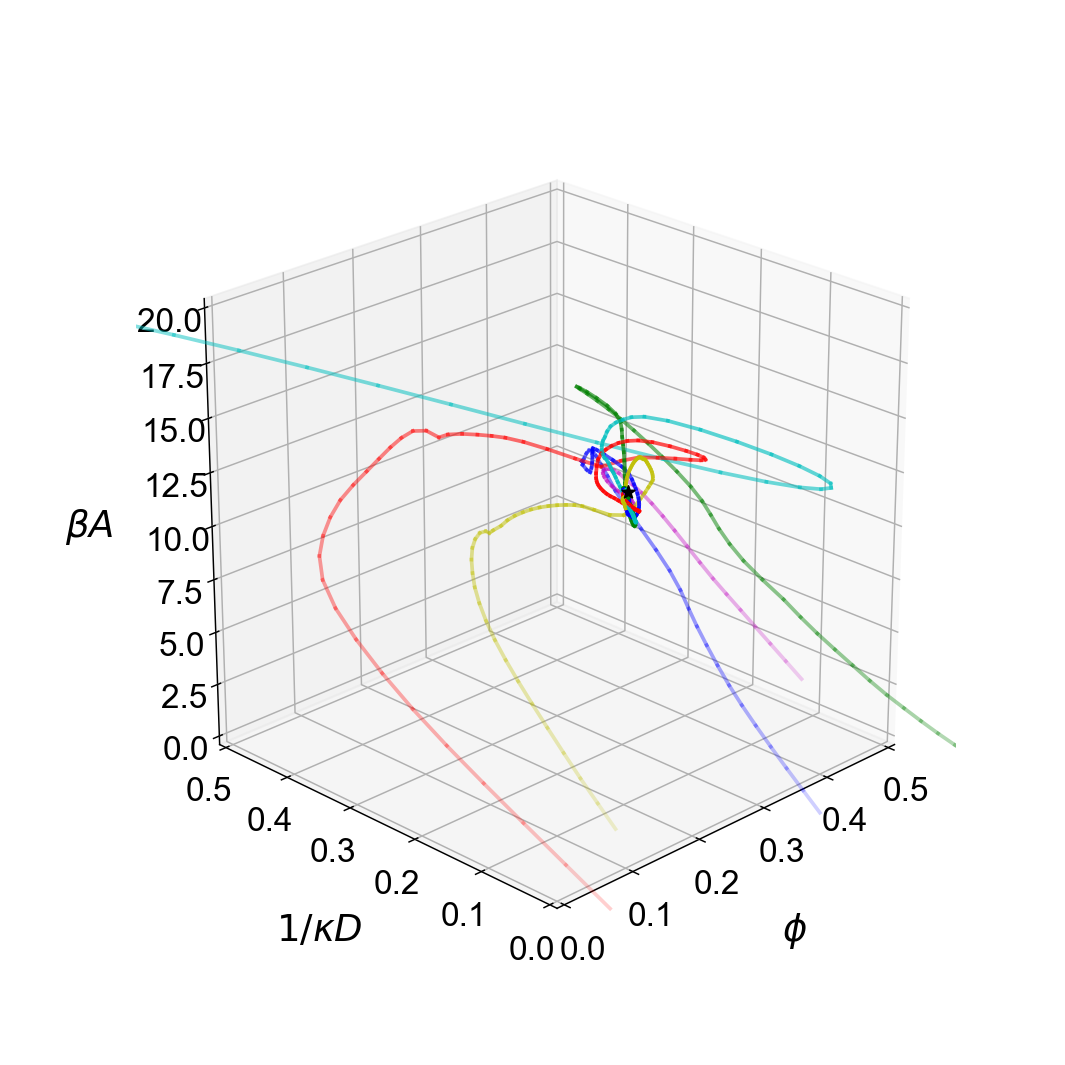

In [51]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.view_init(elev=24, azim=225)
ax.set_xlabel(r'$\phi$',fontsize=20,labelpad=20)
ax.set_ylabel(r'$1/ \kappa D$',fontsize=20,labelpad=20)
ax.set_zlabel(r'$\beta A$',fontsize=20,labelpad=20)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.set_zlim([0, 20])
ax.set_box_aspect([1,1,1])
ax.tick_params(labelsize=18)

colors = ['r','g','b','c','m','y','orange','pink']

eta_all = []
kappa_all = []
lnA_all = []
for i in range(6):
    with np.load('./figures_SQ_cVAE_MSE_ns/fit/parameters/fit_pp_{:0d}.npz'.format(i)) as data:
        eta_i_0=data['eta_i'][:,0]
        kappa_i_0=data['kappa_i'][:,0]
        lnA_i_0=np.exp(data['lnA_i'][:,0])
        eta_i = savitzky_golay(eta_i_0, 51, 3)
        kappa_i = savitzky_golay(kappa_i_0, 51, 3)
        lnA_i = savitzky_golay(lnA_i_0, 51, 3)
        eta_err_i=data['eta_err_i']
        kappa_err_i=data['kappa_err_i']
        lnA_err_i=data['lnA_err_i']
    
    eta_all.append(eta_i)
    kappa_all.append(kappa_i)
    lnA_all.append(lnA_i)
    
ax.scatter(eta_i[-1], kappa_i[-1], lnA_i[-1], 
    c='k',
    s=50,
    marker='*')
    
for j in range(len(eta_i)):
    if j==0:
        continue
        
    for i in range(6):
        alpha0 = 0.1
        ax.plot([eta_all[i][j-1],eta_all[i][j]], 
                [kappa_all[i][j-1],kappa_all[i][j]], 
                [lnA_all[i][j-1],lnA_all[i][j]],
                '-',color = colors[i],alpha=alpha0+(1-alpha0)*np.sqrt(j/len(eta_i)),lw=2)
        
    if j%4 == 0:
        scatter_name = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_pp_{:04d}'
        plt.savefig(scatter_name.format(j), dpi=96)
        
plt.show()
#if 1:
    #scatter_name = './figures_SQ_cVAE_MSE_ns/fit/scatter_6SP'
    #plt.savefig(scatter_name)

<IPython.core.display.Javascript object>


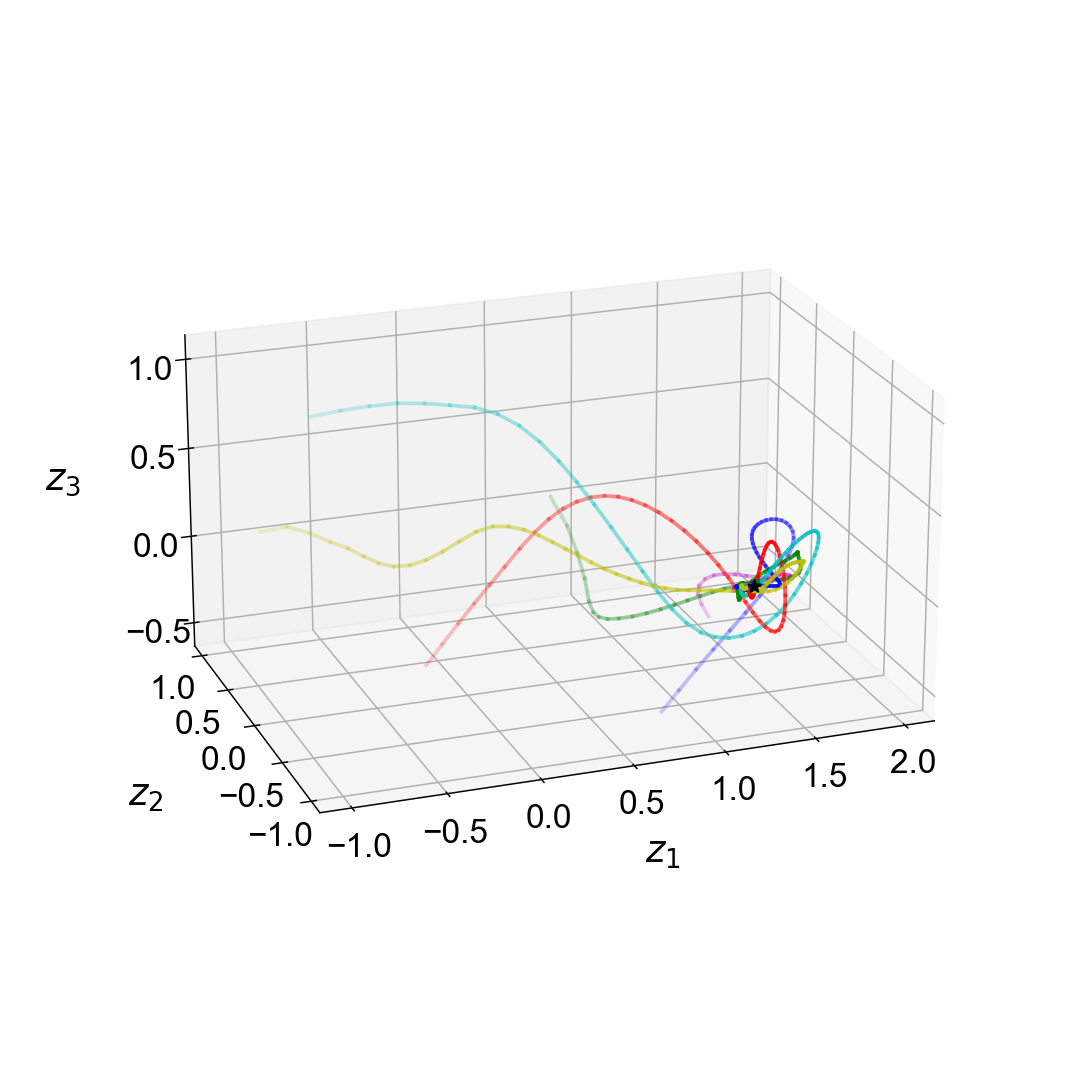

In [52]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.view_init(elev=21, azim=250)
ax.set_xlabel(r'$z_1$',fontsize=20,labelpad=20)
ax.set_ylabel(r'$z_2$',fontsize=20,labelpad=20)
ax.set_zlabel(r'$z_3$',fontsize=20,labelpad=20)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlim(-1.1,2.1)
ax.set_ylim(-1.1,1.1)
ax.set_zlim(-0.6,1.1)
ax.set_xticks([-1,-0.5,0,0.5,1,1.5,2])
ax.set_yticks([-1,-0.5,0,0.5,1])
ax.set_zticks([-0.5,0,0.5,1])
# ax.set_box_aspect([7,2,2.5])
ax.set_box_aspect([3.2,2.2,1.7])
ax.tick_params(labelsize=18)

colors = ['r','g','b','c','m','y','orange','pink']

fp_epoch_all = []
for i in range(6):
    with np.load('./figures_SQ_cVAE_MSE_ns/fit/parameters/fit_pp_{:0d}.npz'.format(i)) as data:
        fp_epoch = np.matmul((data['fp_epoch'][:,0:3]-z_mean),U)*sgn

    fp_epoch_all.append(fp_epoch)
    
ax.scatter(fp_epoch[-1][0], fp_epoch[-1][1], fp_epoch[-1][2], 
    c='k',
    s=50,
    marker='*')
    
for j in range(len(eta_i)):
    if j==0:
        continue
        
    for i in range(6):
        alpha0 = 0.1
        ax.plot([fp_epoch_all[i][j-1][0],fp_epoch_all[i][j][0]], 
                [fp_epoch_all[i][j-1][1],fp_epoch_all[i][j][1]], 
                [fp_epoch_all[i][j-1][2],fp_epoch_all[i][j][2]],
                '-',color = colors[i],alpha=alpha0+(1-alpha0)*np.sqrt(j/len(eta_i)),lw=2)
        
    if j%4 == 0:
        scatter_name = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_z_{:04d}'
        plt.savefig(scatter_name.format(j), dpi=96)
        
plt.show()
#if 1:
    #scatter_name = './figures_SQ_cVAE_MSE_ns/fit/scatter_6SP'
    #plt.savefig(scatter_name)


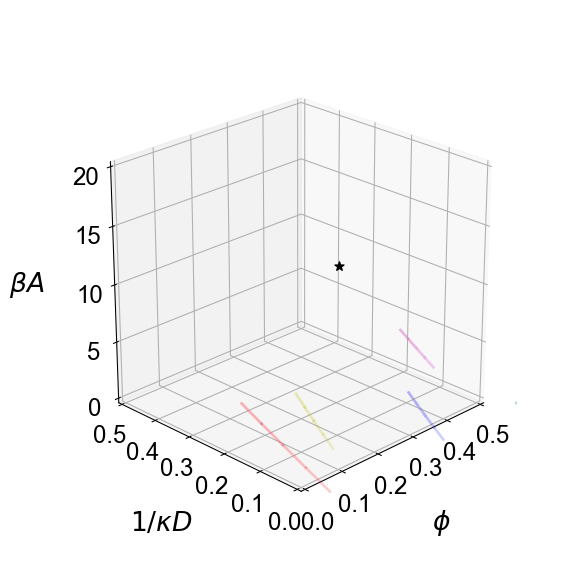

In [53]:
anim_file = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_pp.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_pp_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


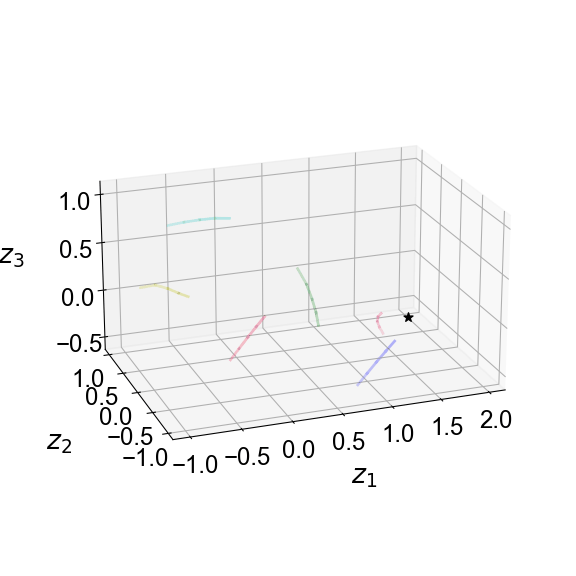

In [54]:
anim_file = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_z.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_z_*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

<IPython.core.display.Javascript object>


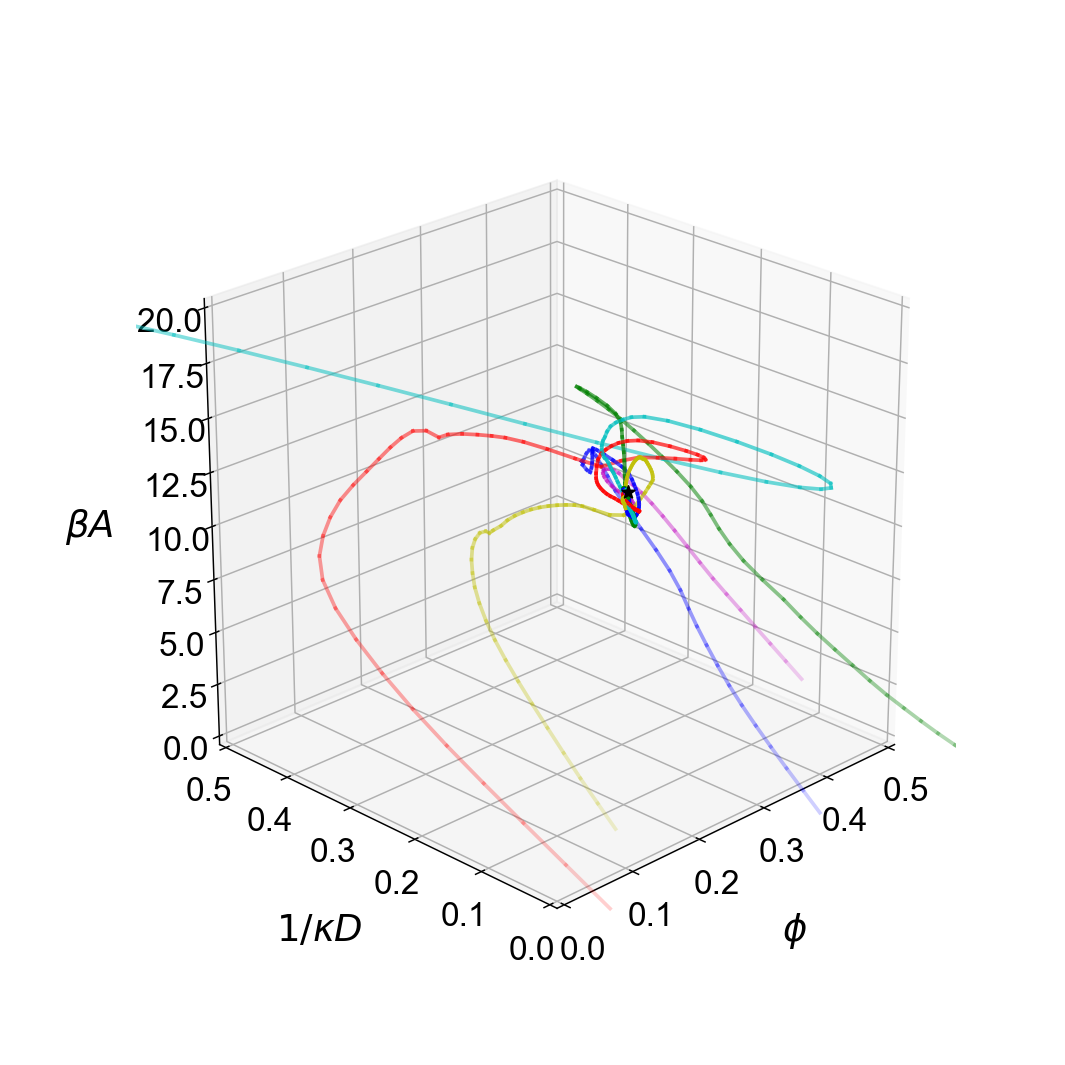

In [55]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')

ax.view_init(elev=24, azim=225)
ax.set_xlabel(r'$\phi$',fontsize=20,labelpad=20)
ax.set_ylabel(r'$1/ \kappa D$',fontsize=20,labelpad=20)
ax.set_zlabel(r'$\beta A$',fontsize=20,labelpad=20)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlim([0, 0.5])
ax.set_ylim([0, 0.5])
ax.set_zlim([0, 20])
ax.set_box_aspect([1,1,1])
ax.tick_params(labelsize=18)

colors = ['r','g','b','c','m','y','orange','pink']

eta_all = []
kappa_all = []
lnA_all = []
for i in range(6):
    with np.load('./figures_SQ_cVAE_MSE_ns/fit/parameters/fit_pp_{:0d}.npz'.format(i)) as data:
        eta_i_0=data['eta_i'][:,0]
        kappa_i_0=data['kappa_i'][:,0]
        lnA_i_0=np.exp(data['lnA_i'][:,0])
        eta_i = savitzky_golay(eta_i_0, 51, 3)
        kappa_i = savitzky_golay(kappa_i_0, 51, 3)
        lnA_i = savitzky_golay(lnA_i_0, 51, 3)
        eta_err_i=data['eta_err_i']
        kappa_err_i=data['kappa_err_i']
        lnA_err_i=data['lnA_err_i']
    
    eta_all.append(eta_i)
    kappa_all.append(kappa_i)
    lnA_all.append(lnA_i)
    
ax.scatter(eta_i[-1], kappa_i[-1], lnA_i[-1], 
    c='k',
    s=50,
    marker='*')
    
for j in range(len(eta_i)):
    if j==0:
        continue
        
    for i in range(6):
        alpha0 = 0.1
        ax.plot([eta_all[i][j-1],eta_all[i][j]], 
                [kappa_all[i][j-1],kappa_all[i][j]], 
                [lnA_all[i][j-1],lnA_all[i][j]],
                '-',color = colors[i],alpha=alpha0+(1-alpha0)*np.sqrt(j/len(eta_i)),lw=2)
        
    if j == len(eta_i)-1:
        scatter_name = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_ppfinal'
        plt.savefig(scatter_name, dpi=300)
        
plt.show()
#if 1:
    #scatter_name = './figures_SQ_cVAE_MSE_ns/fit/scatter_6SP'
    #plt.savefig(scatter_name)

<IPython.core.display.Javascript object>


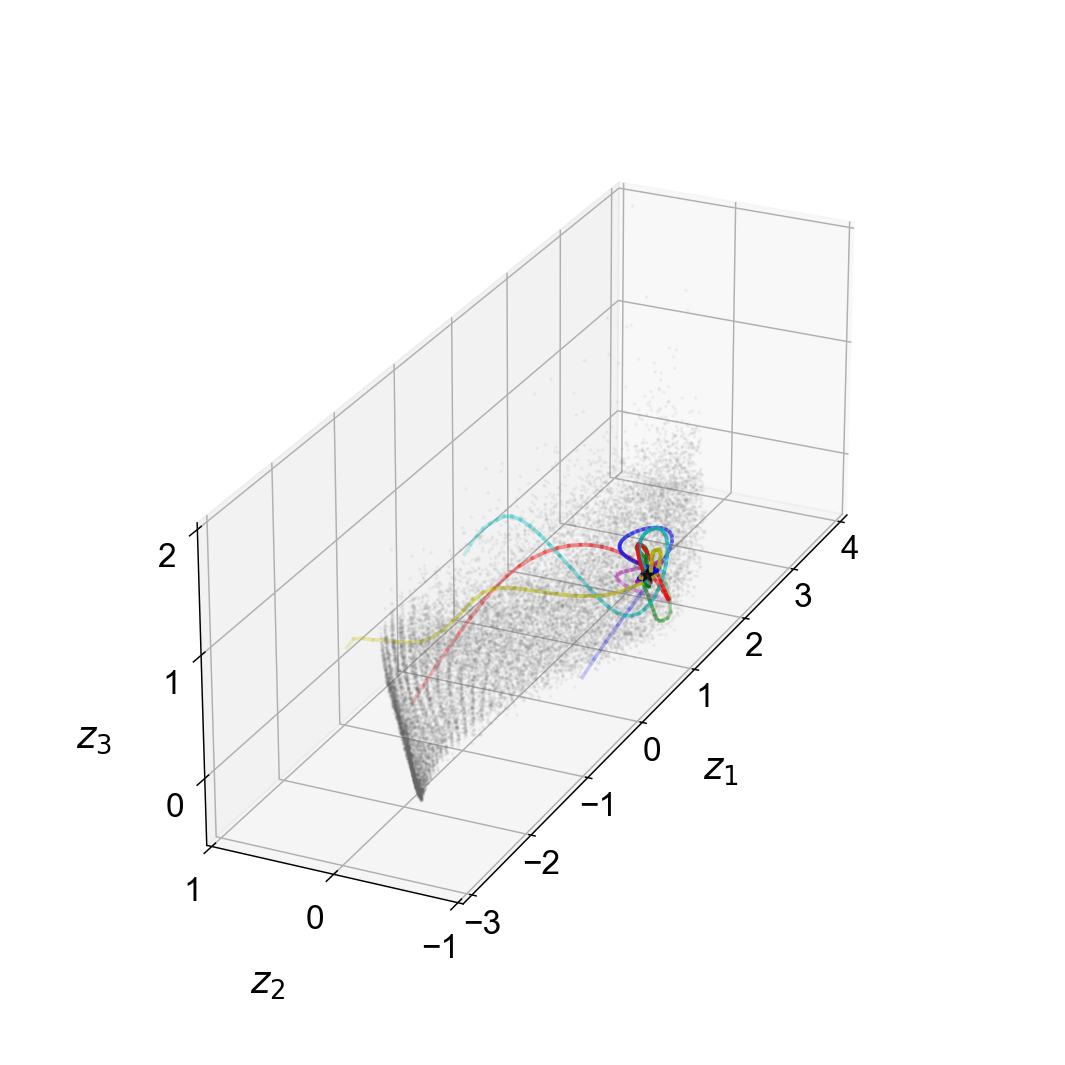

In [56]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
fig.tight_layout()
ax.set_xlabel(r'$z_1$',fontsize=20,labelpad=40)
ax.set_ylabel(r'$z_2$',fontsize=20,labelpad=20)
ax.set_zlabel(r'$z_3$',fontsize=20,labelpad=20)
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)

ax.view_init(elev=25, azim=205)
ax.set_xlim(-3,4)
ax.set_ylim(-1,1)
ax.set_zlim(-0.5,2)
ax.set_xticks([-3,-2,-1,0,1,2,3,4])
ax.set_yticks([-1,0,1])
ax.set_zticks([0,1,2])
ax.set_box_aspect([7,2,2.5])

# xmax = 2.1
# xmin = 0.9
# ymax = 0.8
# ymin = -0.8
# zmax = 0.5
# zmin = -0.5
# ax.view_init(elev=21, azim=250)
# ax.set_xlim(xmin,xmax)
# ax.set_ylim(ymin,ymax)
# ax.set_zlim(zmin,zmax)
# ax.set_xticks([1,1.5,2])
# ax.set_yticks([-0.5,0,0.5])
# ax.set_zticks([-0.5,0,0.5])
# ax.set_box_aspect([xmax-xmin,ymax-ymin,zmax-zmin])

ax.tick_params(labelsize=18)

colors = ['r','g','b','c','m','y','orange','pink']

fp_epoch_all = []
for i in range(6):
    with np.load('./figures_SQ_cVAE_MSE_ns/fit/parameters/fit_pp_{:0d}.npz'.format(i)) as data:
        fp_epoch = np.matmul((data['fp_epoch'][:,0:3]-z_mean),U)*sgn

    fp_epoch_all.append(fp_epoch)
    
ax.scatter(fp_epoch[-1][0], fp_epoch[-1][1], fp_epoch[-1][2], 
    c='k',
    s=50,
    marker='*')
    
for j in range(len(eta_i)):
    if j==0:
        continue
        
    for i in range(6):
        alpha0 = 0.1
        ax.plot([fp_epoch_all[i][j-1][0],fp_epoch_all[i][j][0]], 
                [fp_epoch_all[i][j-1][1],fp_epoch_all[i][j][1]], 
                [fp_epoch_all[i][j-1][2],fp_epoch_all[i][j][2]],
                '-',color = colors[i],alpha=alpha0+(1-alpha0)*np.sqrt(j/len(eta_i)),lw=2)        
        
    if j == len(eta_i)-1:
        ax.scatter(zs[index_eta,0], zs[index_eta,1], zs[index_eta,2], 
                   c='#666666',alpha=0.05,
                   s=1)
#         ax.w_xaxis.set_pane_color((0,1,1, 0.125))
#         ax.w_yaxis.set_pane_color((1,0,1, 0.125))
#         ax.w_zaxis.set_pane_color((1,1,0, 0.125))
        scatter_name = './figures_SQ_cVAE_MSE_ns/fit/parameters/scatter_6SP_zfinal'
        plt.savefig(scatter_name, dpi=300)
        
plt.show()
#if 1:
    #scatter_name = './figures_SQ_cVAE_MSE_ns/fit/scatter_6SP'
    #plt.savefig(scatter_name)

In [57]:
zs

array([[-2.8194218 , -0.55850464,  0.04459539],
       [-2.819475  , -0.5554094 ,  0.04127773],
       [-2.8271694 , -0.56051964,  0.03871133],
       ...,
       [ 2.2912526 , -0.29369092,  0.4078652 ],
       [ 1.9971902 , -0.4678866 ,  0.17511392],
       [ 2.4035273 , -0.25445297,  0.4681151 ]], dtype=float32)